This file just vaguely documents **some** previous experimentations. It's not particularly clean since it's not exactly a finished product or anything, but gives a gist of Word2Vec experiments at least. 

In [1]:
import dask.dataframe as dd
ddf = dd.read_json("goodreads_reviews_dedup.json",lines=True,nrows=10000)
df = ddf.compute()

In [2]:
df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0


In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [4]:
df = df[df['rating'] != 0]
df.reset_index(drop=True, inplace=True)
df = df[['review_text','rating']]

In [5]:
#rest of this came from the wine medium article

# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Text preprocessing function
def preprocess_text(text: str) -> str:
    # Text cleaning
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df['review_text_tokenized'] = df['review_text'].apply(preprocess_text)

In [7]:
# Tokenize the text and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review_text_tokenized'])
sequences = tokenizer.texts_to_sequences(df['review_text_tokenized'])

# Pad sequences to a fixed length
max_sequence_length = 100  # Maximum sequence length to pad
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['rating'], test_size=0.2)

In [8]:
from gensim.models import Word2Vec

# Train the Word2Vec model on the tokenized reviews
word2vec_model = Word2Vec(sentences=df['review_text_tokenized'], vector_size=100, window=5, min_count=1, workers=4)

In [9]:
import numpy as np

# Assuming your tokenized reviews are already in 'df['tokenized_reviews']' as lists of tokens
embedding_dim = 100  # This should match the size of your Word2Vec vectors

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


## Regression

In [13]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

C:\Users\harin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 2.3406 - val_loss: 1.0204
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 1.0208 - val_loss: 1.0244
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 1.0184 - val_loss: 0.9615
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.9910 - val_loss: 0.9397
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.9371 - val_loss: 0.9605
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.9450 - val_loss: 0.9312
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.9112 - val_loss: 0.8964
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.9150 - val_loss: 0.8904
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.9120 - val_loss: 0.8996
Epoch 10/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.8946 - val_loss: 0.8945
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Mean Squared Error: 0.8945


In [19]:
model.save('trained_model/10k_model_word2vec.keras') #i think this will save it to hpc

In [15]:
#this is to just make sure it worked 
from keras.models import load_model

# Load the trained model
loaded_model = load_model('trained_model/10k_model_word2vec.keras')
def predict_review_score(review_text: str) -> float:
    # Preprocess the review text
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    # Make the prediction using the loaded model
    predicted_score = loaded_model.predict(padded_sequence)[0][0]

    return predicted_score

# Sample review to predict the score
sample_review = "Mind blowingly cool. Best science fiction I've read in some time. I just loved all the descriptions of the society of the future - how they lived in trees, the notion of owning property or even getting married was gone. How every surface was a screen. The undulations of how society responds to the Trisolaran threat seem surprising to me. Maybe its more the Chinese perspective, but I wouldn't have thought the ETO would exist in book 1, and I wouldn't have thought people would get so over-confident in our primitive fleet's chances given you have to think that with superior science they would have weapons - and defenses - that would just be as rifles to arrows once were. But the moment when Luo Ji won as a wallfacer was just too cool. I may have actually done a fist pump. Though by the way, if the Dark Forest theory is right - and I see no reason why it wouldn't be - we as a society should probably stop broadcasting so much signal out into the universe."
# Call the function to predict the score
predicted_score = predict_review_score(sample_review)
print(f"Predicted Score: {predicted_score:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Predicted Score: 3.80


word2vec did not improve regression performance. let's try it for classification. 

In [18]:
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# One-hot encode the target labels
y_train_onehot = to_categorical(y_train-1, num_classes=5)  # Adjust the number of classes if needed
y_test_onehot = to_categorical(y_test-1, num_classes=5)
# Build the LSTM model for classification
model_class = Sequential()
model_class.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model_class.add(LSTM(64))
model_class.add(Dropout(0.1))
model_class.add(Dense(5, activation='softmax'))  # 5 classes for multi-class classification

# Compile the model
model_class.compile(loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              optimizer='adam',
              metrics=['accuracy'])  # Use accuracy as the metric

# Train the model
model_class.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot), verbose=True)

# Evaluate the model
y_pred = model_class.predict(X_test)
# Since y_pred will be the probabilities for each class, you need to convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

# If y_test is in categorical format, you can convert it to the class labels
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Evaluate the performance
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.3747 - loss: 1.3238 - val_accuracy: 0.3935 - val_loss: 1.3039
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4043 - loss: 1.2809 - val_accuracy: 0.4283 - val_loss: 1.2638
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4339 - loss: 1.2409 - val_accuracy: 0.4262 - val_loss: 1.2598
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4335 - loss: 1.2428 - val_accuracy: 0.4439 - val_loss: 1.2600
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.4420 - loss: 1.2307 - val_accuracy: 0.4376 - val_loss: 1.2480
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.4463 - loss: 1.2325 - val_accuracy: 0.4454 - val_loss: 1.2263
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.4665 - loss: 1.2091 - val_accuracy: 0.4470 - val_loss: 1.2326
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4687 - loss: 1.1892 - val_acc

In [20]:
model_class.save('trained_model/10k_model_word2vec_classification.keras') #i think this will save it to hpc

also bad. let's try a pretrained word2vec.

In [22]:
pip install gensim --user


  Obtaining dependency information for FuzzyTM>=0.4.0 from https://files.pythonhosted.org/packages/2d/30/074bac7a25866a2807c1005c7852c0139ac22ba837871fc01f16df29b9dc/FuzzyTM-2.0.9-py3-none-any.whl.metadata
  Using cached FuzzyTM-2.0.9-py3-none-any.whl.metadata (7.9 kB)
  Obtaining dependency information for pyfume from https://files.pythonhosted.org/packages/ed/ea/a3b120e251145dcdb10777f2bc5f18b1496fd999d705a178c1b0ad947ce1/pyFUME-0.3.4-py3-none-any.whl.metadata
  Using cached pyFUME-0.3.4-py3-none-any.whl.metadata (9.7 kB)
  Obtaining dependency information for simpful==2.12.0 from https://files.pythonhosted.org/packages/9d/0e/aebc2fb0b0f481994179b2ee2b8e6bbf0894d971594688c018375e7076ea/simpful-2.12.0-py3-none-any.whl.metadata
  Using cached simpful-2.12.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached fst_pso-1.8.1-py3-none-any.whl
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/da/6d/1235da14daddaa6e47f74ba0c255358f0ce7a6ee05da8bf8eb491

In [57]:
from gensim.models import KeyedVectors

# Load the model
word2vec_model = KeyedVectors.load_word2vec_format("crawl-300d-2M.vec", binary=False)

In [58]:
print(f"Loaded model with {len(word2vec_model.key_to_index)} words.")

Loaded model with 1999995 words.


In [59]:
import numpy as np

# Initialize the embedding matrix with zeros
embedding_dim = 300  # As the model is 200D
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Populate the embedding matrix with word vectors from Word2Vec
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

# Check the shape of the embedding matrix
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (66459, 300)


In [51]:
# alt version
embedding_dim = 300  # Dimension of the embeddings (should match Word2Vec's embedding size)
embedding_matrix_2 = np.random.normal(scale=0.6, size=(len(tokenizer.word_index) + 1, embedding_dim))

# Populate the embedding matrix with Word2Vec vectors where available
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:  # Check if the word is in the Word2Vec model
        embedding_matrix_2[i] = word2vec_model[word]

# Check the shape of the embedding matrix
print(f"Embedding matrix shape: {embedding_matrix_2.shape}")

Embedding matrix shape: (53255, 300)


In [52]:
np.save("embedding_matrix_2.npy", embedding_matrix_2)
embedding_matrix = np.load("embedding_matrix_2.npy")

In [60]:
np.save("embedding_matrix.npy", embedding_matrix)

In [61]:
embedding_matrix = np.load("embedding_matrix.npy")

# Verify the shape of the loaded matrix
print(f"Loaded embedding matrix shape: {embedding_matrix.shape}")

Loaded embedding matrix shape: (66459, 300)


In [23]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.1487      0.0488      0.1016     ...  0.0244     -0.0725
   0.0789    ]
 [ 0.0699     -0.1028      0.29750001 ...  0.0296      0.2094
   0.1542    ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [48]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 2.8644 - val_loss: 0.8836
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.9172 - val_loss: 0.7538
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 0.8147 - val_loss: 0.7115
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.7662 - val_loss: 0.6894
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.7145 - val_loss: 0.6740
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.6741 - val_loss: 0.6765
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.6545 - val_loss: 0.6636
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - loss: 0.6065 - val_loss: 0.6804
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.5967 - val_loss: 0.6774
Epoch 10/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.5468 - val_loss: 0.6611
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Mean Squared Error: 0.6611


In [16]:
model.save('trained_model/10k_model_word2vec_pretrained.keras') #i think this will save it to hpc

In [20]:
#this is to just make sure it worked 
from keras.models import load_model

# Load the trained model
loaded_model = load_model('trained_model/10k_model_word2vec_pretrained.keras')
def predict_review_score(review_text: str) -> float:
    # Preprocess the review text
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    # Make the prediction using the loaded model
    predicted_score = loaded_model.predict(padded_sequence)[0][0]

    return predicted_score

# Sample review to predict the score
sample_review = "Mind blowingly cool. Best science fiction I've read in some time. I just loved all the descriptions of the society of the future - how they lived in trees, the notion of owning property or even getting married was gone. How every surface was a screen. The undulations of how society responds to the Trisolaran threat seem surprising to me. Maybe its more the Chinese perspective, but I wouldn't have thought the ETO would exist in book 1, and I wouldn't have thought people would get so over-confident in our primitive fleet's chances given you have to think that with superior science they would have weapons - and defenses - that would just be as rifles to arrows once were. But the moment when Luo Ji won as a wallfacer was just too cool. I may have actually done a fist pump. Though by the way, if the Dark Forest theory is right - and I see no reason why it wouldn't be - we as a society should probably stop broadcasting so much signal out into the universe."
# Call the function to predict the score
predicted_score = predict_review_score(sample_review)
print(f"Predicted Score: {predicted_score:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Predicted Score: 4.43


In [21]:
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# One-hot encode the target labels
y_train_onehot = to_categorical(y_train-1, num_classes=5)  # Adjust the number of classes if needed
y_test_onehot = to_categorical(y_test-1, num_classes=5)
# Build the LSTM model for classification
model_class = Sequential()
model_class.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model_class.add(LSTM(64))
model_class.add(Dropout(0.1))
model_class.add(Dense(5, activation='softmax'))  # 5 classes for multi-class classification

# Compile the model
model_class.compile(loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              optimizer='adam',
              metrics=['accuracy'])  # Use accuracy as the metric

# Train the model
model_class.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot), verbose=True)

# Evaluate the model
y_pred = model_class.predict(X_test)
# Since y_pred will be the probabilities for each class, you need to convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

# If y_test is in categorical format, you can convert it to the class labels
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Evaluate the performance
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.4000 - loss: 1.3278 - val_accuracy: 0.4574 - val_loss: 1.1692
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.4864 - loss: 1.1392 - val_accuracy: 0.4964 - val_loss: 1.1163
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5256 - loss: 1.0882 - val_accuracy: 0.5000 - val_loss: 1.1008
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.5412 - loss: 1.0485 - val_accuracy: 0.4969 - val_loss: 1.1196
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.5692 - loss: 1.0009 - val_accuracy: 0.4974 - val_loss: 1.1101
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5952 - loss: 0.9579 - val_accuracy: 0.4880 - val_loss: 1.1151
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6248 - loss: 0.9017 - val_accuracy: 0.4917 - val_loss: 1.1367
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.6626 - loss: 0.8385 - 

In [22]:
model_class.save('trained_model/10k_model_word2vec_classification_pretrained.keras') #i think this will save it to hpc

so the pretrained word2vec embeddings improved our regression performance! we can continue using it going forward. classification continues to underfit. let's try adding more layers now. let's also make the output layer relu activated since we only want positive values. we made the lstm bidirectional to capture more information. and let's use a learning rate scheduler. 

In [31]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))  # Ensuring output is in a positive range

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - loss: 3.0882 - val_loss: 0.8248 - learning_rate: 0.0010
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.8448 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - loss: 0.7745 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.7030 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - loss: 0.6728 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.5960 - val_loss: 0.6620 - learning_rate: 0.0010
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.5962 - val_loss: 0.7669 - learning_rate: 0.0010
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.5559 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.4855 - val_loss: 0.6889 - learning_rate:

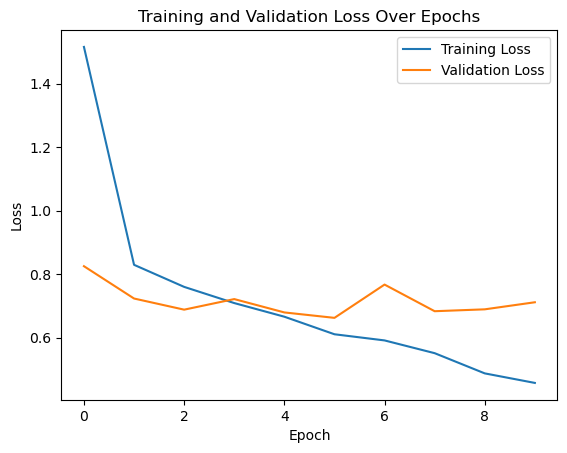

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [33]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))  # Ensuring output is in a positive range

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 3.2378 - val_loss: 0.8385
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.9118 - val_loss: 0.8348
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.7860 - val_loss: 0.7366
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.7280 - val_loss: 0.6811
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.6945 - val_loss: 0.6821
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.6508 - val_loss: 0.7197
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.6104 - val_loss: 0.7088
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.5680 - val_loss: 0.6936
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.5291 - val_loss: 0.7221
Epoch 10/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.4745 - val_loss: 0.7127
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Mean Squared Error: 0.7127


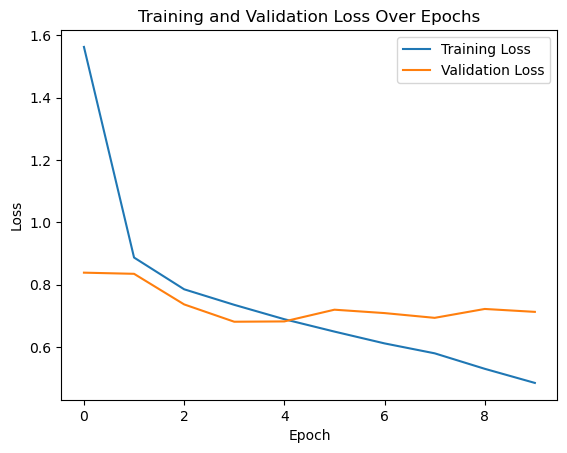

In [34]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [39]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))  # Ensuring output is in a positive range

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - loss: 3.0497 - val_loss: 0.8823
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.9244 - val_loss: 0.7409
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 0.7841 - val_loss: 0.7322
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.7689 - val_loss: 0.7229
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.6954 - val_loss: 0.7522
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.6877 - val_loss: 0.6813
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 0.6652 - val_loss: 0.6610
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.6160 - val_loss: 0.6598
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.6133 - val_loss: 0.6731
Epoch 10/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.5755 - val_loss: 0.6658
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Mean Squared Error: 0.6658


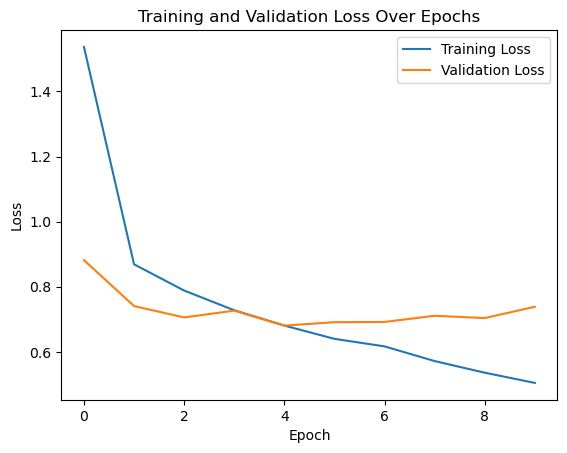

In [38]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [40]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Use pretrained embeddings
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))  # Ensuring output is in a positive range

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - loss: 3.2390 - val_loss: 0.7955
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - loss: 0.8947 - val_loss: 0.7453
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - loss: 0.8605 - val_loss: 0.7055
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.7669 - val_loss: 0.6498
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - loss: 0.7242 - val_loss: 0.6356
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - loss: 0.6937 - val_loss: 0.6624
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.6473 - val_loss: 0.6331
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.6224 - val_loss: 0.6587
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.6203 - val_loss: 0.6458
Epoch 10/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - loss: 0.5493 - val_loss: 0.6865
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
Mean Squared Error: 0.6865


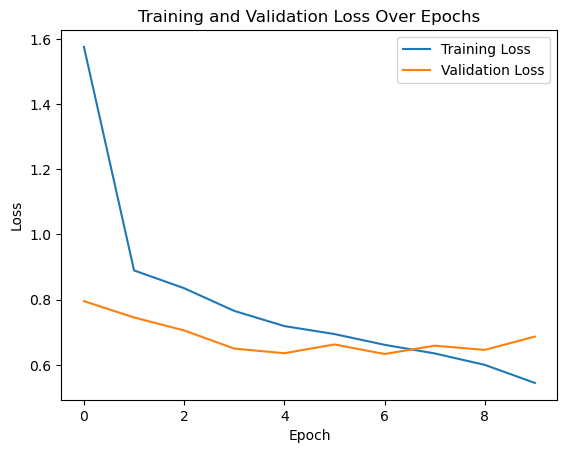

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [49]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=True))  # Use pretrained embeddings
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))  # Ensuring output is in a positive range

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - loss: 2.9890 - val_loss: 0.8597
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.7717 - val_loss: 0.7334
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.4395 - val_loss: 0.7201
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.2978 - val_loss: 0.7421
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 0.2049 - val_loss: 0.7503
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - loss: 0.1537 - val_loss: 0.8059
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.1307 - val_loss: 0.7851
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - loss: 0.1140 - val_loss: 0.7943
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - loss: 0.0990 - val_loss: 0.7798
Epoch 10/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - loss: 0.0908 - val_loss: 0.7826
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Mean Squared Error: 0.7826


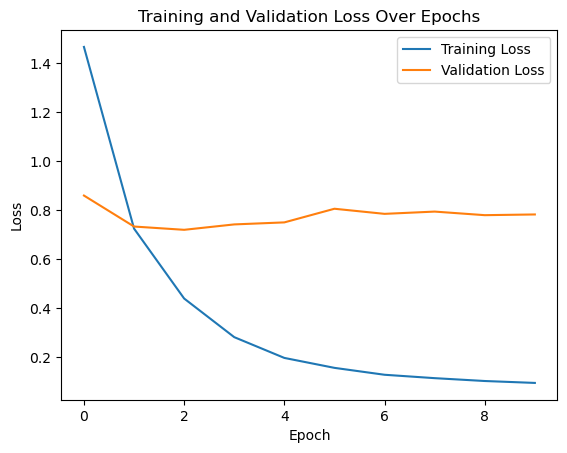

In [53]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [62]:
import dask.dataframe as dd
ddf = dd.read_json("goodreads_reviews_dedup.json",lines=True,nrows=30000)
df = ddf.compute()

In [63]:
df = df[df['rating'] != 0]
df.reset_index(drop=True, inplace=True)
df = df[['review_text','rating']]
df['review_text_tokenized'] = df['review_text'].apply(preprocess_text)

In [64]:
# Tokenize the text and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review_text_tokenized'])
sequences = tokenizer.texts_to_sequences(df['review_text_tokenized'])

# Pad sequences to a fixed length
max_sequence_length = 400  # Maximum sequence length to pad
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['rating'], test_size=0.2)

In [67]:
embedding_dim = 300  # As the model is 300D
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Populate the embedding matrix with word vectors from Word2Vec
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

# Now, the embedding matrix has the right shape for your tokenizer
# The embedding matrix shape should now match (len(tokenizer.word_index) + 1, embedding_dim)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (107549, 300)


In [69]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=True))  # Use pretrained embeddings
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 233s 313ms/step - loss: 1.6535 - val_loss: 0.6299
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 187s 257ms/step - loss: 0.4917 - val_loss: 0.6171
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 196s 270ms/step - loss: 0.3058 - val_loss: 0.6319
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 211s 289ms/step - loss: 0.2203 - val_loss: 0.6257
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 196s 270ms/step - loss: 0.1698 - val_loss: 0.6849
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 207s 285ms/step - loss: 0.1380 - val_loss: 0.6668
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 217s 298ms/step - loss: 0.1152 - val_loss: 0.6776
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 192s 263ms/step - loss: 0.1102 - val_loss: 0.6977
Epoch 9/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 189s 260ms/step - loss: 0.0917 - val_loss: 0.6652
Epoch 10/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 185s 254ms/step - loss: 0.0855 - val_loss: 0.6864
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step
Mean Squared Error: 0.6864


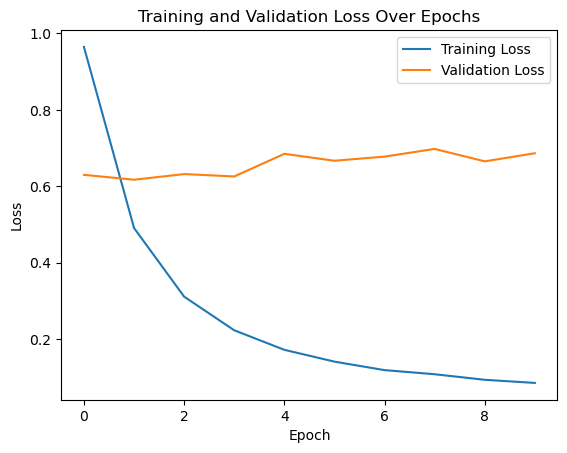

In [70]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [73]:
print(len([num for num in y_pred if num>5]))

262


In [ ]:
#use smote. creates synthetic data for lower class. or ideally decrease instances in majority classes. try v100 gpu instead?
#ask for minimum 4 hours
#colab t4 gpu <- could handle 1.5 gpu. find someone who has gpu in their device or go to gaming centers at nyu that have gpu access. 